# Analysis of generated data

## Imports and setup

In [1]:
import logging
import warnings

import cloudpathlib
import dask.dataframe as dd
import helpers
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import scipy.stats
from statsmodels.stats.multitest import multipletests

In [2]:
from tqdm.autonotebook import tqdm

tqdm.pandas()

/tmp/ipykernel_19447/2614673571.py:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
logger = logging.getLogger(__name__)
logger.setLevel("DEBUG")

# helpers.logging.configure_logging()
udp_handler = logging.handlers.DatagramHandler("localhost", 12000)
udp_handler.setLevel("DEBUG")
stream_handler = logging.StreamHandler()
stream_handler.setFormatter(helpers.logging.formatter)
stream_handler.setLevel("INFO")
logging.getLogger().handlers = [udp_handler, stream_handler]

In [4]:
path_root = cloudpathlib.CloudPath(
    "gs://liulab/evaluating_cibersortx/identical_cohorts/2022-08-25_05:53:48/"
)

## Load generated data

What does DEG analysis look like for the in silico generated cohorts?

A priori, no genes are differentially expressed... But checking differential expression gives us a baseline of what to expect in terms of false discovery of DEGs.

In [6]:
def load_simulated_bulkrnaseq():
    # uri = "gs://liulab/evaluating_cibersortx/identical_cohorts/2022-08-11_03:41:30/*/data/bulkrnaseq.txt"
    uri = str(path_root / "running_individually" / "*" / "pseudobulk_rnaseq.tsv")
    df = dd.read_csv(uri, sep="\t", include_path_column=True).compute()
    df[["cohort_id"]] = df["path"].str.extract(".*/(.*)/pseudobulk_rnaseq.tsv")
    df = df.drop(columns="path")
    df = df.pivot(index=["cohort_id", "GeneSymbol"], columns=[])
    df = df.rename_axis(columns="sample_id")
    df = df.stack()
    # df = df.set_index(["cohort_id", "GeneSymbol"])
    return df

In [7]:
%%time
df_bulkrnaseq = load_simulated_bulkrnaseq()

CPU times: user 3.93 s, sys: 352 ms, total: 4.29 s
Wall time: 3.92 s


In [8]:
df_bulkrnaseq

cohort_id  GeneSymbol  sample_id                   
0          A1BG        TCGA-3N-A9WB-06A-11R-A38C-07     44.044627
                       TCGA-3N-A9WC-06A-11R-A38C-07     89.240604
                       TCGA-3N-A9WD-06A-11R-A38C-07     60.240547
                       TCGA-BF-AAP0-06A-11R-A39D-07     53.463504
                       TCGA-D3-A1Q1-06A-21R-A18T-07    131.733534
                                                          ...    
1          ZZZ3        TCGA-YG-AA3O-06A-11R-A38C-07     60.696120
                       TCGA-YG-AA3P-06A-11R-A38C-07    104.668394
                       TCGA-Z2-A8RT-06A-11R-A37K-07     12.266973
                       TCGA-Z2-AA3S-06A-11R-A39D-07     36.512972
                       TCGA-Z2-AA3V-06A-11R-A39D-07    126.039951
Length: 11822368, dtype: float64

## PCA summary of the data

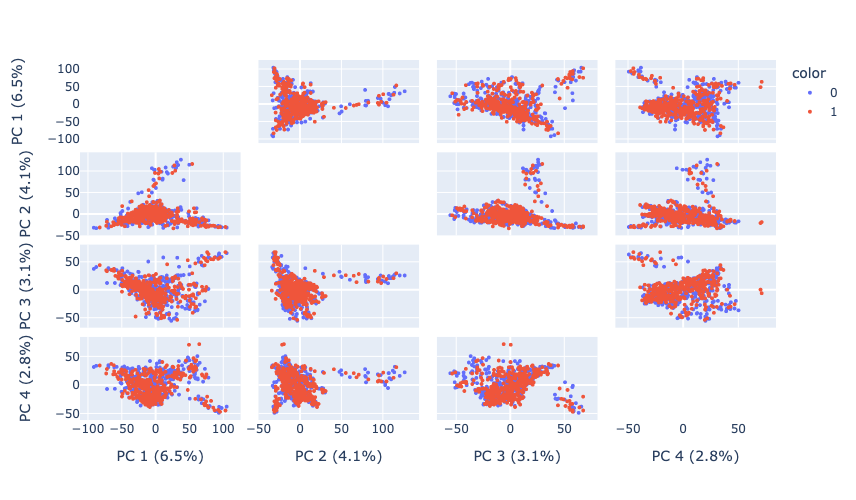

In [62]:
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


def make_pca_grid_fig(df, n_components):
    """
    df: a dataframe with index = [cohort_id, sample_id], columns = [GeneSymbol]
    """
    pca = PCA(n_components=n_components)
    pipeline = Pipeline([("scaling", StandardScaler()), ("pca", pca)])
    components = pipeline.fit_transform(df)
    labels = {
        str(i): f"PC {i+1} ({var:.1f}%)"
        for i, var in enumerate(pca.explained_variance_ratio_ * 100)
    }
    fig = px.scatter_matrix(
        components,
        labels=labels,
        dimensions=range(n_components),
        color=df.index.get_level_values("cohort_id"),
        # hover_data=["sample_id"],
    )
    fig.update_traces(diagonal_visible=False)
    fig.update_layout(
        yaxis=dict(scaleanchor="x", scaleratio=1),
        # autosize=False,
        # width="100%",
        height=500,
    )
    fig.update_traces(marker=dict(size=4))
    return fig


make_pca_grid_fig(df_bulkrnaseq.unstack("GeneSymbol"), 4)